In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
from torchvision.datasets import FashionMNIST


# Hyperparameters
IMG_SIZE = 28
PATCH_SIZE = 4
NUM_CLASSES = 10
EMBED_DIM = 128
NUM_HEADS = 4
NUM_LAYERS = 6
MLP_DIM = 256
DROPOUT = 0.1
BATCH_SIZE = 64
EPOCHS = 5
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Helper: Flatten patches
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=1, embed_dim=128):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_dim = patch_size * patch_size * in_channels
        self.proj = nn.Linear(self.patch_dim, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.unfold(2, PATCH_SIZE, PATCH_SIZE).unfold(3, PATCH_SIZE, PATCH_SIZE)
        x = x.contiguous().view(B, C, -1, PATCH_SIZE, PATCH_SIZE)
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        x = x.view(B, -1, self.patch_dim)  # (B, num_patches, patch_dim)
        return self.proj(x)

# Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer
class TinyViT(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes,
                 embed_dim, num_heads, mlp_dim, depth, dropout):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2 + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)
        self.transformer = nn.Sequential(*[
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        B, N, _ = x.shape
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed[:, :N + 1]
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.norm(x[:, 0])
        return self.head(x)

Using device: cpu


In [2]:
# Data
TinyViT_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=TinyViT_transform, download=True)
# test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=TinyViT_transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

TinyViT_dataset = FashionMNIST(root="./data", train=True, download=True, transform=TinyViT_transform)
TinyViT_test_dataset = FashionMNIST(root="./data", train=False, download=True, transform=TinyViT_transform)

train_size = int(0.9 * len(TinyViT_dataset))
val_size = len(TinyViT_dataset) - train_size
TinyViT_train_dataset, TinyViT_valid_dataset = random_split(TinyViT_dataset, [train_size, val_size])

TinyViTTrainLoader = DataLoader(TinyViT_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
TinyViTValidLoader = DataLoader(TinyViT_valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
TinyViTTestLoader = DataLoader(TinyViT_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Model
model = TinyViT(IMG_SIZE, PATCH_SIZE, 1, NUM_CLASSES,
                EMBED_DIM, NUM_HEADS, MLP_DIM, NUM_LAYERS, DROPOUT).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [3]:
# Train
def train(model, loader):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [4]:
# Eval
def evaluate(model, loader):
    model.eval()
    total = correct = loss_sum = 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return loss_sum / len(loader), 100 * correct / total

In [ ]:
# Main loop
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    train_loss = train(model, TinyViTTrainLoader)
    val_loss, val_acc = evaluate(model, TinyViTTestLoader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

torch.save(model.state_dict(), "tiny_vit_fashionmnist.pth")
print("✅ Model saved as tiny_vit_fashionmnist.pth")

Training:  50%|████▉     | 420/844 [02:26<02:18,  3.06it/s]

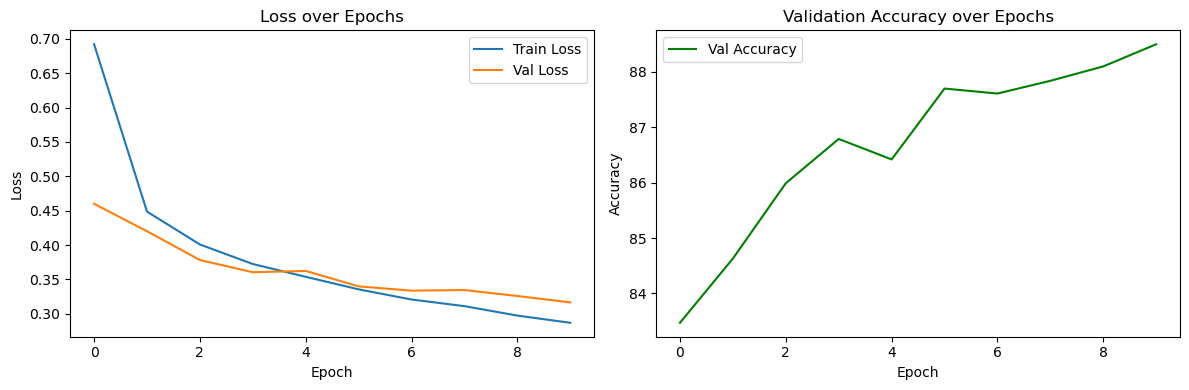

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


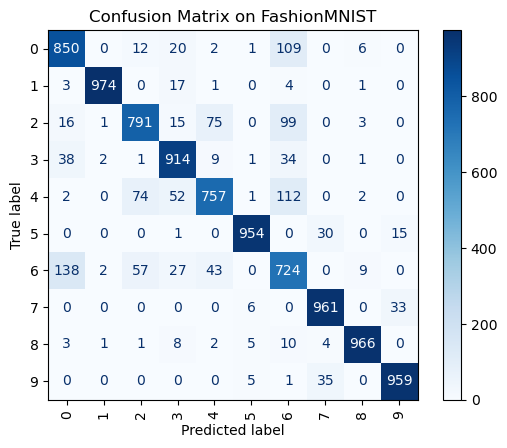

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get all predictions and true labels
all_preds = []
all_labels = []

model.eval()
device = "cpu"
with torch.no_grad():
    for images, labels in TinyViTTestLoader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate and display confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix on FashionMNIST")
plt.show()
